<a href="https://colab.research.google.com/github/KarynaSam/Python-DS/blob/main/HW_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scikit-surprise
!pip install scikit-optimize
!pip install pandas-profiling

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3156238 sha256=86a8beab95adcd01dd7a6e735c7a93d57598935927457244aa68b653205ee60a
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.3/357.3 kB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 47.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from surprise import SVD, SVDpp, NMF
from surprise import Dataset
from surprise.model_selection import cross_validate
from scipy.io import loadmat
from scipy.optimize import minimize
import pandas as pd
from IPython.display import display_html


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling

def display_side_by_side(*args):
  html_str = ""
  for df in args:
    html_str += df.to_html()
  display_html(html_str.replace("table", "table style=display:inline"), raw=True)

<ipython-input-3-ee480ecbf6f0>:13: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling


**Завдання:**

Пропонуємо вам познайомитись з бібліотекою surprise, котра якраз є по суті додатком до знайомої нам бібліотеки scikit-learn для тренування моделей рекомендаційних систем.

Візьміть датасет movielens і побудуйте модель матричної факторизації. У даній бібліотеці він має назву SVD. Підберіть найкращі параметри за допомогою крос-валідації, також поекспериментуйте з іншими алгоритмами розрахунків (SVD++, NMF) і оберіть той, який буде оптимальним.

Підказки як саме побудувати дану модель ви знайдете в документації до даної бібліотеки.

In [5]:
data = Dataset.load_builtin('ml-100k')

Dataset ml-100k could not be found. Do you want to download it? [Y/n] Y
Trying to download dataset from https://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k


**EDA by hand**

Загальна інформація про дані:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    100000 non-null  object 
 1   item_id    100000 non-null  object 
 2   rating     100000 non-null  float64
 3   timestamp  100000 non-null  object 
dtypes: float64(1), object(3)
memory usage: 3.1+ MB
None 

Розподіл оцінок:
count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64 

Кількість оцінок, зроблених кожним користувачем (топ-10 користувачів):
405    737
655    685
13     636
450    540
276    518
416    493
537    490
303    484
234    480
393    448
Name: user_id, dtype: int64 

Кількість оцінок для кожного фільму (топ-10 фільмів):
50     583
258    509
100    508
181    507
294    485
286 

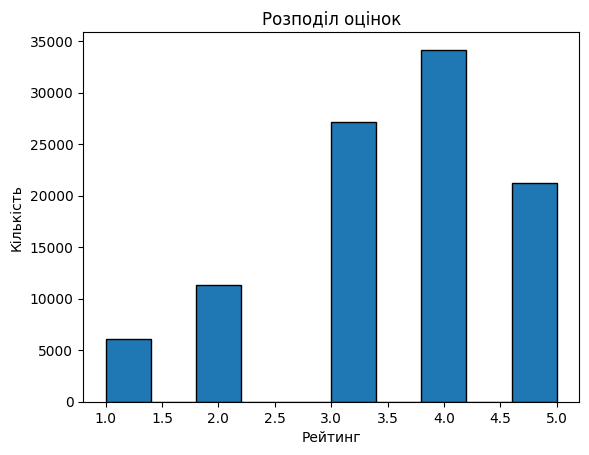

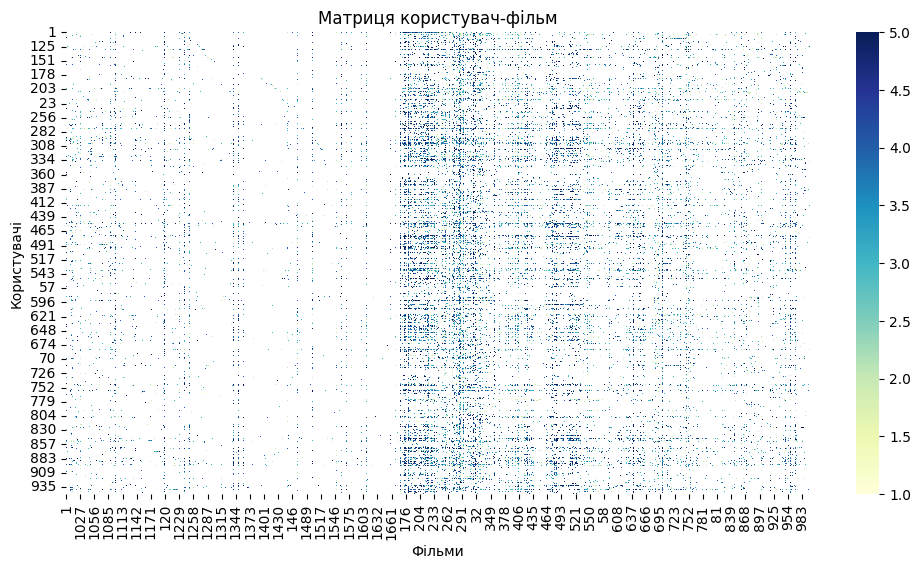

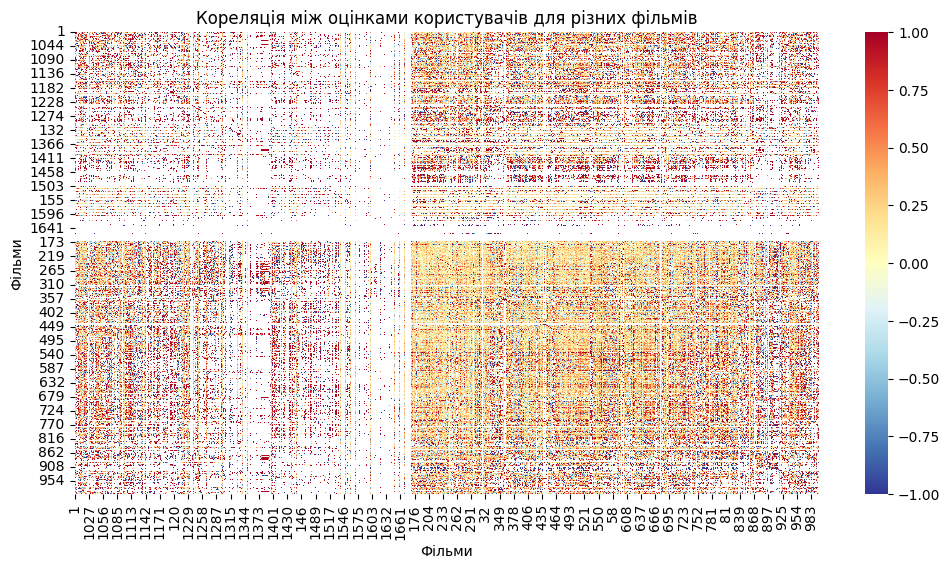

In [6]:
df = pd.DataFrame(data.raw_ratings, columns=['user_id', 'item_id', 'rating', 'timestamp'])

# Дослідження загальної структури даних
print("Загальна інформація про дані:")
print(df.info(), "\n")

# Розподіл оцінок
print("Розподіл оцінок:")
print(df['rating'].describe(), "\n")

# Дослідження користувачів та фільмів
user_counts = df['user_id'].value_counts()
movie_counts = df['item_id'].value_counts()

print("Кількість оцінок, зроблених кожним користувачем (топ-10 користувачів):")
print(user_counts.head(10), "\n")

print("Кількість оцінок для кожного фільму (топ-10 фільмів):")
print(movie_counts.head(10), "\n")

# Візуалізація розподілу оцінок
plt.hist(df['rating'], bins=10, edgecolor='black')
plt.xlabel('Рейтинг')
plt.ylabel('Кількість')
plt.title('Розподіл оцінок')
plt.show()

ratings_matrix = df.pivot_table(index='user_id', columns='item_id', values='rating')

# Візуалізація матриці користувач-фільм
plt.figure(figsize=(12, 6))
sns.heatmap(ratings_matrix, cmap='YlGnBu')
plt.title('Матриця користувач-фільм')
plt.xlabel('Фільми')
plt.ylabel('Користувачі')
plt.show()

# Кореляція між оцінками користувачів для різних фільмів
correlation_matrix = ratings_matrix.corr()

# Візуалізація матриці кореляції
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix, cmap='RdYlBu_r', center=0)
plt.title('Кореляція між оцінками користувачів для різних фільмів')
plt.xlabel('Фільми')
plt.ylabel('Фільми')
plt.show()

**EDA with pandas_profiling**

In [7]:
df = pd.DataFrame(data.raw_ratings, columns=['user_id', 'item_id', 'rating', 'timestamp'])

# Створення звіту EDA за допомогою pandas_profiling
profile = pandas_profiling.ProfileReport(df)
profile.to_file("data_eda_report.html")  # Збереження звіту в HTML

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
profile

**Крос-валідація для оцінки точності моделей**

In [9]:
algo_1 = SVD()
algo_2 = SVDpp()
algo_3 = NMF()
algorithms = [algo_1, algo_2, algo_3]

Оцінюємо у циклі усі алгоритми та записуємо результати

In [10]:
results = []
for algorithm in algorithms:
  result = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
  results.append((algorithm, result))

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9327  0.9352  0.9383  0.9399  0.9347  0.9361  0.0026  
MAE (testset)     0.7327  0.7382  0.7399  0.7414  0.7373  0.7379  0.0030  
Fit time          5.42    3.05    1.46    1.35    1.44    2.54    1.57    
Test time         0.39    0.13    0.13    0.15    0.14    0.19    0.10    
Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9179  0.9226  0.9179  0.9218  0.9212  0.9203  0.0020  
MAE (testset)     0.7211  0.7229  0.7200  0.7220  0.7229  0.7218  0.0011  
Fit time          28.00   32.44   27.94   27.98   31.22   29.52   1.93    
Test time         4.95    6.33    4.17    4.16    4.93    4.91    0.79    
Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (tests

Вибираємо найкращій з алгоритмів, надаючи перевагу точності над часом (ваги легко переналаштовуються та аналогічно додаються до вагів ще 2 показника за потреби)

In [11]:
best_weighted_error = float('inf')
best_algorithm = None
best_test_time = None

rmse_weight = 0.6  # Вага для RMSE
test_time_weight = 0.4  # Вага для test_time

for algorithm, result in results:
    rmse = np.mean(result['test_rmse'])
    test_time = np.mean(result['test_time'])

    weighted_error = rmse_weight * rmse + test_time_weight * test_time

    if weighted_error < best_weighted_error:
        best_weighted_error = weighted_error
        best_algorithm = algorithm
        best_test_time = test_time

print(f"Найкраща збалансована модель: {best_algorithm}")
print(f"Сумарна зважена похибка: {best_weighted_error:.4f}")
print(f"Зважений час виконання: {best_test_time:.4f} сек")

Найкраща збалансована модель: <surprise.prediction_algorithms.matrix_factorization.NMF object at 0x7fba1241a0b0>
Сумарна зважена похибка: 0.6283
Зважений час виконання: 0.1247 сек


Завдання з зірочкою

Для більшого заглиблення в роботу алгоритму, пропонуємо реалізувати алгоритм колабораційної фільтрації з нуля. Для цього ми можемо скористатись нашою домашньою роботою з 3-ого модуля. Якщо ми модифікуємо функцію втрат та розрахунок градієнтів, то зможемо побудувати алгоритм матричної факторизації.

Тут ви можете побачити формули та завантаження датасету. А ось посилання на назви фільмів та на рейтинги.

Вдалої роботи!

In [12]:
def loadMovieList(file_path):

    with open(file_path, encoding='ISO-8859-1') as fid:
        movies = fid.readlines()

    movieNames = []
    for movie in movies:
        parts = movie.split()
        movieNames.append(' '.join(parts[1:]).strip())
    return movieNames

# Отримання списку назв фільмів
file_path = '/content/drive/MyDrive/HW_7/movie_ids.txt'
movie_names = loadMovieList(file_path)

In [13]:
data = loadmat('/content/drive/MyDrive/HW_7/movies.mat')
Y, R = data['Y'], data['R']

З матриці ми можемо обчислити статистику, наприклад середній рейтинг

In [14]:
movie_index = 1
average_rating = np.mean(Y[movie_index - 1, R[movie_index - 1, :]])

print('Середній рейтинг для фільму №', movie_index, '(', movie_names[movie_index - 1], '): %.2f / 5' % average_rating)

Середній рейтинг для фільму № 1 ( Toy Story (1995) ): 4.52 / 5


Ми можемо "візуалізувати" матрицю рейтингів, побудувавши її графік за допомогою imshow

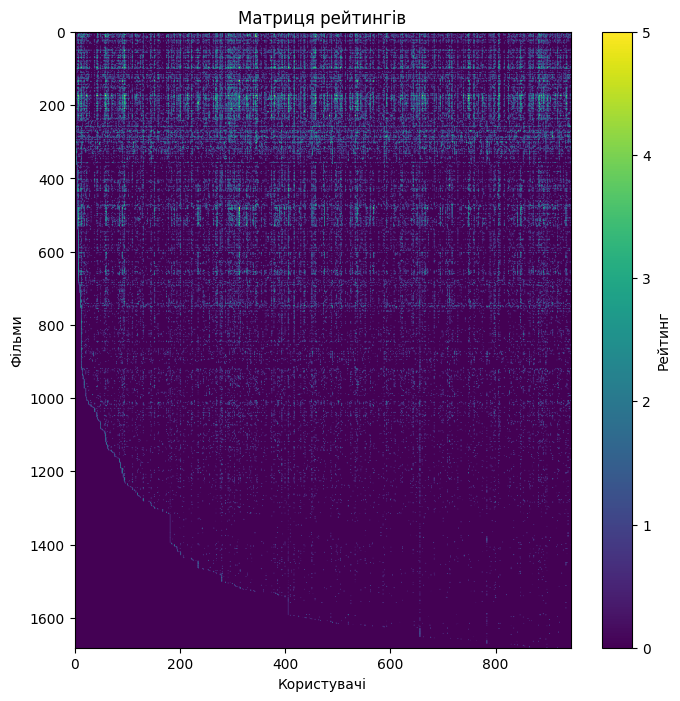

In [15]:
plt.figure(figsize=(8, 8))
plt.imshow(Y, aspect='auto', cmap='viridis')
plt.ylabel('Фільми')
plt.xlabel('Користувачі')
plt.title('Матриця рейтингів')
plt.colorbar(label='Рейтинг')
plt.grid(False)
plt.show()

Ми можемо "візуалізувати" розподіл рейтингів для фільму відповідно до movie_index.

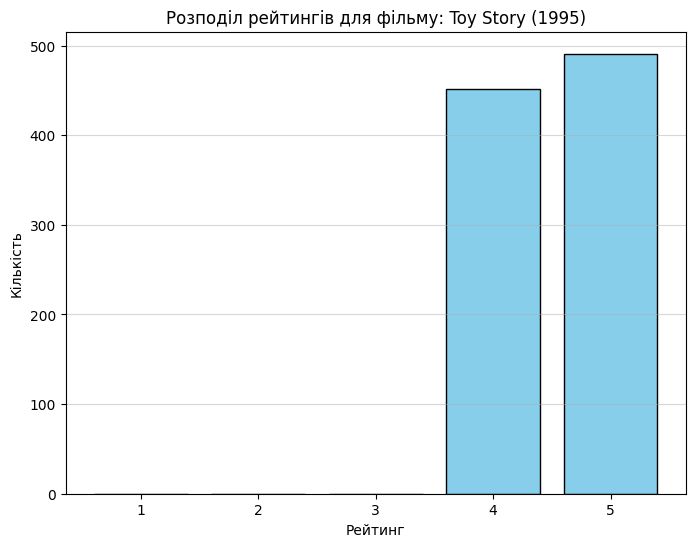

In [16]:
movie_ratings = Y[movie_index - 1, R[movie_index - 1, :]]
plt.figure(figsize=(8, 6))
plt.hist(movie_ratings, bins=np.arange(1, 7) - 0.5, rwidth=0.8, align='mid', edgecolor='black', color='skyblue')
plt.xticks(np.arange(1, 6))
plt.xlabel('Рейтинг')
plt.ylabel('Кількість')
plt.title('Розподіл рейтингів для фільму: ' + movie_names[movie_index - 1])
plt.grid(axis='y', alpha=0.5)
plt.show()

Надрукуємо 20 найкращих фільмів

In [17]:
# Обчислюємо середні рейтинги для кожного фільму
average_ratings = np.sum(Y, axis=1) / np.sum(R, axis=1)

# Створюємо список кортежів, що містить (movie_name, average_rating)
movies_with_ratings = list(zip(movie_names, average_ratings))

# Відсортуємо фільми за середніми оцінками в порядку спадання
movies_with_ratings.sort(key=lambda x: x[1], reverse=True)

print("Топ 20 фільмів:")
for i, (movie, rating) in enumerate(movies_with_ratings[:20], 1):
    print(f"{i}. {movie}: {rating:.2f} / 5")

Топ 20 фільмів:
1. Great Day in Harlem, A (1994): 5.00 / 5
2. They Made Me a Criminal (1939): 5.00 / 5
3. Prefontaine (1997): 5.00 / 5
4. Marlene Dietrich: Shadow and Light (1996): 5.00 / 5
5. Star Kid (1997): 5.00 / 5
6. Saint of Fort Washington, The (1993): 5.00 / 5
7. Santa with Muscles (1996): 5.00 / 5
8. Aiqing wansui (1994): 5.00 / 5
9. Someone Else's America (1995): 5.00 / 5
10. Entertaining Angels: The Dorothy Day Story (1996): 5.00 / 5
11. Pather Panchali (1955): 4.62 / 5
12. Maya Lin: A Strong Clear Vision (1994): 4.50 / 5
13. Anna (1996): 4.50 / 5
14. Everest (1998): 4.50 / 5
15. Some Mother's Son (1996): 4.50 / 5
16. Close Shave, A (1995): 4.49 / 5
17. Schindler's List (1993): 4.47 / 5
18. Wrong Trousers, The (1993): 4.47 / 5
19. Casablanca (1942): 4.46 / 5
20. Wallace & Gromit: The Best of Aardman Animation (1996): 4.45 / 5


Побудова системи колобораційної фільтрації
Функція втрат

In [18]:
def cofiCostFunc(params, Y, R, num_users, num_movies, num_features, lam=0.0):

    """
Обчислює вартість і градієнт спільної фільтрації
     функція витрат.

     Параметри
     ----------
     параметри: масив
         Параметри моделі.
     Y : масив
         Матриця рейтингів.
     R : масив
         Матриця індикаторних змінних.
     num_users : int
         Кількість користувачів.
     кількість_фільмів: внутр
         Кількість фільмів.
     num_features : внутр
         Кількість функцій.
     lam : плавати
         Параметр регуляризації.

     Повернення
     -------
     J : плавати
         Вартість моделі.
     grad : масив
         Градієнт моделі.
    """

    X = params[:num_movies * num_features].reshape((num_movies, num_features))
    Theta = params[num_movies * num_features:].reshape((num_users, num_features))

    J = 0
    grad = np.zeros_like(params)

    X_grad = np.zeros_like(X)
    Theta_grad = np.zeros_like(Theta)

    error = (X @ Theta.T) * R - Y
    J += 0.5 * np.sum(error**2) + 0.5 * lam * (np.sum(X**2) + np.sum(Theta**2))

    X_grad = error @ Theta + lam * X
    Theta_grad = error.T @ X + lam * Theta

    grad[:num_movies * num_features] = X_grad.flatten()
    grad[num_movies * num_features:] = Theta_grad.flatten()

    return J, grad

Побудова системи фільтрації

In [19]:
def collaborative_filtering(Y, R, num_features, lambda_val, num_iterations, learning_rate):
    num_movies, num_users = Y.shape

    # Довільно ініціалізуємо фільм і матрицю рейтингів користувача
    X = np.random.randn(num_movies, num_features)
    Theta = np.random.randn(num_users, num_features)

    # Для оптимізації об’єднуємо матриці в один масив параметрів
    initial_parameters = np.concatenate((X.flatten(), Theta.flatten()))

    # Визначаємо функцію для оптимізації витрат
    def cost_func(params):
        return cofiCostFunc(params, Y, R, num_users, num_movies, num_features, lambda_val)[0]

    # Визначаємо функцію градієнтного спуску
    def gradient_func(params):
        return cofiCostFunc(params, Y, R, num_users, num_movies, num_features, lambda_val)[1]

    # Виконуємо оптимізацію градієнтного спуску
    result = minimize(cost_func, initial_parameters, jac=gradient_func, method='CG', options={'maxiter': num_iterations, 'disp': True})

    # Повертаємо оптимізовані матриці фільмів і  користувачів
    X_optimized = result.x[:num_movies * num_features].reshape((num_movies, num_features))
    Theta_optimized = result.x[num_movies * num_features:].reshape((num_users, num_features))


    return X_optimized, Theta_optimized

Встановлюємо гіперпараметри нашої моделі та навчаємо її

In [20]:
num_features = 10
lambda_val = 10  # Regularization parameter
num_iterations = 1000
learning_rate = 0.01

# Виконуємо розкладання матриці на множники
X, Theta = collaborative_filtering(Y, R, num_features, lambda_val, num_iterations, learning_rate)


# Розрахуємо прогнози для всіх користувачів
predictions = X @ Theta.T

         Current function value: 71873.418521
         Iterations: 1000
         Function evaluations: 1480
         Gradient evaluations: 1480


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:703: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_cg(fun, x0, args, jac, callback, **options)


Надаємо рекомендації конкретному користувачу (топ-10)

In [21]:
def recommend_movies(predictions, user_index, num_recommendations=10):
    sorted_indices = np.argsort(predictions[:, user_index - 1])[::-1]
    top_movie_indices = sorted_indices[:num_recommendations]
    return top_movie_indices + 1  # Додаємо 1 до індексів фільму, щоб відповідати оригінальним даним

user_index = 110
recommendations = recommend_movies(predictions, user_index, num_recommendations=10)

print(f"Toп 10 рекомендованих фільмів для користувача {user_index}:", "\n")
for i, movie_index in enumerate(recommendations, 1):
    print(f"{i}. {movie_names[movie_index - 1]}")

Toп 10 рекомендованих фільмів для користувача 110: 

1. Titanic (1997)
2. Braveheart (1995)
3. Shawshank Redemption, The (1994)
4. Time to Kill, A (1996)
5. Schindler's List (1993)
6. Forrest Gump (1994)
7. As Good As It Gets (1997)
8. Mr. Holland's Opus (1995)
9. Good Will Hunting (1997)
10. American President, The (1995)


Формуємо передбачення від конкретного користувача щодо рейтингу фільмів, які він ще не бачив.

In [22]:
def predict_ratings(X, Theta, user_index, movie_indices):
    user_ratings = X[movie_indices - 1] @ Theta[user_index - 1].T
    return user_ratings

user_index = 222 # Можна замінити на потрібні індекси користувача
movie_indices_to_predict = np.array([3, 5, 12, 200, 400, 600, 800, 1000, 1200, 1600])  # Можна замінити на потрібні індекси фільму

existing_ratings = Y[movie_indices_to_predict - 1, user_index - 1]
existing_mask = R[movie_indices_to_predict - 1, user_index - 1] == 1

predicted_ratings = predict_ratings(X, Theta, user_index, movie_indices_to_predict)

# Відкоригуємо прогнози для вже існуючих рейтингів
predicted_ratings[existing_mask] = existing_ratings[existing_mask]

print("Прогнозовані оцінки від користувача", user_index, "\n")
for i, movie_index in enumerate(movie_indices_to_predict, 1):
    print(f"Фільм {movie_names[movie_index - 1]}:  Існуючий рейтинг {existing_ratings[i-1]}, Прогнозований рейтинг {predicted_ratings[i - 1]:.2f}")

Прогнозовані оцінки від користувача 222 

Фільм Four Rooms (1995):  Існуючий рейтинг 0, Прогнозований рейтинг 3.49
Фільм Copycat (1995):  Існуючий рейтинг 0, Прогнозований рейтинг 3.02
Фільм Usual Suspects, The (1995):  Існуючий рейтинг 5, Прогнозований рейтинг 5.00
Фільм Shining, The (1980):  Існуючий рейтинг 3, Прогнозований рейтинг 3.00
Фільм Little Rascals, The (1994):  Існуючий рейтинг 0, Прогнозований рейтинг 2.08
Фільм Daniel Defoe's Robinson Crusoe (1996):  Існуючий рейтинг 0, Прогнозований рейтинг 1.08
Фільм In the Mouth of Madness (1995):  Існуючий рейтинг 0, Прогнозований рейтинг 2.18
Фільм Lightning Jack (1994):  Існуючий рейтинг 0, Прогнозований рейтинг 1.79
Фільм Kim (1950):  Існуючий рейтинг 0, Прогнозований рейтинг 1.86
Фільм Guantanamera (1994):  Існуючий рейтинг 0, Прогнозований рейтинг 1.93
